In [70]:
!pip install imageio
!pip install imageio-ffmpeg
!pip install dmslogo
!pip install palettable
!pip install array_to_latex

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for clipboard: filename=clipboard-0.0.4-py3-none-any.whl size=1848 sha256=933762945cffef23623d6631c18b3840b6c7b543ade4df3efada4bdfad14db8d
  Stored in directory: /root/.cache/pip/wheels/76/06/fa/282b51f270aaab0f9141d8eec9016e29bce0e081861fabd4c8
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=bc9af08b4ea18f98574c0fb2d5e2531fd1ca78b5e2fb98d2912b7c2a6bb3f668
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built clipboard pyperclip
You should consider upgr

In [2]:
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
from torch.distributions.categorical import Categorical

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import seaborn as sns


In [3]:
class ParamsBase(nn.Module):
    def __init__(self):
        super().__init__()
        
    @property
    def shape(self):
        return self().shape
    
    def forward(self):
        raise NotImplementedError("Params forward call not implemented.")
        return None
        
    def rebatch(self, input):
        raise NotImplementedError("Rebatch function not implemented.")
        return None
    
    def prior_nll(self):
        raise NotImplementedError("Prior Negative Log-Likelihood not implemented.")
        return None

In [4]:
class BasicParameters(ParamsBase):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        
    @property
    def shape(self):
        return self().shape

    def forward(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def rebatch(self, input):
        return input


In [5]:
my_params = BasicParameters(
    nn.Parameter(torch.randn([3,4,1])), 
    left_flank=None, 
    right_flank=None
)

In [6]:
class StraightThroughParameters(ParamsBase):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1,
                 n_samples=1,
                 temperature=1.,
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.n_samples = n_samples
        self.temperature = temperature
        
        self.softmax    = nn.Softmax(dim=-1)
        self.num_classes= self.theta.shape[1]
        self.n_dims     = len(self.theta.shape)
        self.batch_size = self.theta.shape[batch_dim]
        
        self.perm_order   = [0] + list(range(2,self.n_dims)) + [1]
        self.reverse_perm = [0,self.n_dims-1] + list(range(1,self.n_dims-1))
                
    @property
    def shape(self):
        return get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_probs_and_dist(self):
        logits = self.get_logits()
        logits = logits.permute( *self.perm_order ) \
                   .div(self.temperature)
        probs  = self.softmax(logits)
        dist   = Categorical(probs=probs)
        return probs, dist
    
    def sample(self):
        probs, dist = self.get_probs_and_dist()
        sample = dist.sample((self.n_samples,))
        sample = F.one_hot(sample, self.num_classes)
        sample = sample - probs.detach() + probs
        sample = sample.flatten(0,1)
        sample = sample.permute( *self.reverse_perm )
        return sample
    
    def forward(self):
        return self.sample()
    
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)
    
class GumbelSoftmaxParameters(ParamsBase):
    def __init__(self,
                 data, 
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1,
                 n_samples=1,
                 tau=1.,
                 prior_var=1.
                ):
        
        super().__init__()
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.n_samples = n_samples
        self.tau = tau
        self.prior_var = prior_var
        
        self.softmax    = nn.Softmax(dim=-1)
        self.num_classes= self.theta.shape[1]
        self.n_dims     = len(self.theta.shape)
        self.batch_size = self.theta.shape[batch_dim]
        
    @property
    def shape(self):
        return get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_sample(self):
        logits = self.get_logits()
        samples= [ F.gumbel_softmax(logits, tau=self.tau, hard=True, dim=1) 
                   for i in range(self.n_samples) ]
        return torch.stack(samples, dim=0)
    
    def forward(self):
        sample = self.get_sample()
        return sample.flatten(0,1)
        
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)
    
    def prior_nll(self):
        return self.theta.transpose(self.batch_dim, 0).flatten(1).pow(2).div(2*self.prior_var).mean(1)

In [7]:
class NUTS3(nn.Module):
    def __init__(self,
                 params,
                 energy_fn,
                 max_tree_depth=10
                ):
        
        super().__init__()
        self.params = params
        self.energy_fn  = energy_fn
        self.max_tree_depth = max_tree_depth
        
        self.d_max = 1000.
        
    def calc_energy(self):
        energy = self.energy_fn(self.params())
        energy = self.params.rebatch( energy )
        try:
            prior = self.params.prior_nll()
            energy= energy + prior
        except NotImplementedError:
            warnings.warn("Prior Negative Log-Likelihood Not Implemented.", RuntimeWarning)
            pass
        return energy

    def leapfrog(self, theta, r, epsilon):
        
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
            theta = theta + r.mul(epsilon)
            
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
        return theta, r, energy
        
    def buildtree(self, theta, r, u, v, j, epsilon):
        #print(f'current j: {j}')
        if j == 0:
            theta_p, r_p, energy_p = self.leapfrog(theta, r, v*epsilon)
            batch_dot = torch.einsum('bs,bs->b', r_p.flatten(1), r_p.flatten(1))
            hamilton  = energy_p + batch_dot.div(2.)
            n_p = (u <= torch.exp(-hamilton)).type(torch.long)
            s_p = (torch.log(u).add(-self.d_max) < -hamilton).type(torch.long)
            #print(f'inner j: {j}')
            #print(f'log u: {u.log()}, -H: {-hamilton}')
            #print(theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p, sep='\n')
            return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
        
        else:
            #print(f'inner j: {j}')
            bt_pack = self.buildtree(theta, r, u, v, j-1, epsilon)
            theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p = bt_pack
            #[print(a) for a in bt_pack]
            if s_p.sum() > 0:
                if v == -1:
                    bt_pack = self.buildtree(theta_r, r_r, u, v, j-1, epsilon)
                    theta_r, r_r, _, _, theta_pp, n_pp, s_pp = bt_pack
                    
                else:
                    bt_pack = self.buildtree(theta_f, r_f, u, v, j-1, epsilon)
                    _, _, theta_f, r_f, theta_pp, n_pp, s_pp = bt_pack
                
                update_flag = torch.rand(n_pp.size(), dtype=torch.float, 
                                         layout=n_pp.layout, device=n_pp.device)
                update_flag = update_flag < n_pp.div( n_p + n_pp )
                update_flag = torch.logical_and(update_flag, s_p.ge(1) )
                theta_p[ update_flag ] = theta_pp[ update_flag ]
                s_p = s_p * s_pp * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                        .ge(0.).type(torch.long) * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                        .ge(0.).type(torch.long)
                n_p = n_p + n_pp
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p)
            return theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p
        
    def init_trajectory(self, theta):
        with torch.no_grad():
            r_0 = torch.randn_like( theta )
            energy_0 = self.calc_energy()
            batch_dot= torch.einsum('bs,bs->b', r_0.flatten(1), r_0.flatten(1))
            hamilton = energy_0 + batch_dot.div(2.)
            u   = torch.rand_like( hamilton ).mul( torch.exp(-hamilton) )
            
            theta_r, theta_f = theta, theta
            r_r, r_f = r_0, r_0
            j = 0
            theta_m = theta
            n = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
            s = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
        return u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s
    
    def sample_trajectory(self, theta, epsilon):
        u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s = self.init_trajectory(theta)
        while (s.sum() >= 1) and (j < self.max_tree_depth):
            v = torch.randn([1], dtype=torch.float, layout=theta.layout, device=theta.device) \
                  .ge(0.).mul(2.).add(-1.)
            if v < 0:
                theta_r, r_r, _, _, theta_p, n_p, s_p = self.buildtree(theta_r, r_r, u, v, j, epsilon)
            else:
                _, _, theta_f, r_f, theta_p, n_p, s_p = self.buildtree(theta_f, r_f, u, v, j, epsilon)
            
            #print('traj results:')
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p, sep='\n')
            update_flag = torch.rand_like(n.type(torch.float))
            update_flag = update_flag <= torch.minimum( n / n_p, torch.ones_like(n.type(torch.float)) )
            update_flag = torch.logical_and( update_flag, s.ge(1) )
            update_flag = torch.logical_and( update_flag, s_p.ge(1) )
            #print(f'update_flag: {update_flag}')
            theta_m[ update_flag ] = theta_p[ update_flag ]
            
            n = n + n_p
            s = s * s_p * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                  .ge(0.).type(torch.long) * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                  .ge(0.).type(torch.long)
            j = j + 1
        
        return theta_m.detach().clone()
    
    def collect_samples(self, epsilon, n_samples=1):
        samples = []
        theta_m = self.params.theta.clone().detach()
        for m in range(n_samples):
            theta_m = self.sample_trajectory( theta_m, epsilon )
            with torch.no_grad():
                self.params.theta.data = theta_m
                samples.append( [theta_m, self.calc_energy()] )
        return samples


In [66]:
class a_frac(nn.Module):
    def __init__(self, frac=0.2):
        super().__init__()
        self.frac = frac
        self.energy = nn.KLDivLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor[:,0,:].mean(1).add(1e-5).log()
        labs  = torch.full_like(score, self.frac)
        return self.energy(score, labs)

class a_frac(nn.Module):
    def __init__(self, frac=0.2):
        super().__init__()
        self.frac = frac
        self.energy = nn.KLDivLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor[:,0,:].mean(1).add(-self.frac).pow(2)
        return score

class a_only(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor.sum(-1)
        targs = torch.zeros(in_tensor.shape[0],
                            layout=in_tensor.layout,
                            device=in_tensor.device).long()
        return self.loss(score, targs)
        
class hard_motif(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.loss  = nn.KLDivLoss(reduction='none', log_target=True)
        
    def forward(self, in_tensor):
        return self.loss( in_tensor, self.motif ).sum(-1).mean(-1)
    
class scan_motif(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.filter= nn.Conv1d(motif.shape[1], motif.shape[0], motif.shape[2], 
                               bias=False)
        self.filter.weight.data = motif
        self.filter.weight.requires_grad = False
        self.activation = nn.LogSigmoid()
        
    def forward(self, in_tensor):
        hook = self.filter(in_tensor)
        hook = hook.max(-1)[0]
        #hook = self.activation(hook)
        hook = hook.mul(-1).sum(-1)
        return hook
    
class run_filter(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.filter= nn.Conv1d(motif.shape[1], motif.shape[0], motif.shape[2], 
                               bias=False)
        self.pad = nn.ConstantPad1d((0,self.filter.weight.shape[-1]-1),motif.min())
        self.filter.weight.data = motif
        self.filter.weight.requires_grad = False

    def forward(self, in_tensor):
        hook = self.filter(in_tensor)
        return self.pad( hook )

class run_filter(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.filter= nn.Conv1d(motif.shape[1], motif.shape[0], motif.shape[2], 
                               bias=False)
        self.padding = self.filter.weight.shape[-1]
        self.filter.weight.data = motif
        self.filter.weight.requires_grad = False

    def forward(self, in_tensor):
        new_shape = (in_tensor.shape[0], in_tensor.shape[1],)
        hook = self.filter(in_tensor)
        hold = []
        for i in range(self.padding):
            left_shape = (hook.shape[0], hook.shape[1],i)
            left_pad   = torch.zeros(size=left_shape, dtype=in_tensor.dtype, 
                                     layout=in_tensor.layout, device=in_tensor.device)
            right_shape= (hook.shape[0], hook.shape[1],self.padding-i-1)
            right_pad  = torch.zeros(size=right_shape, dtype=in_tensor.dtype, 
                                     layout=in_tensor.layout, device=in_tensor.device)
            hold.append( torch.cat([left_pad, hook, right_pad], dim=-1) )
        hook = torch.stack(hold,dim=-1)
        hook = hook.max(dim=-1)[0]#.clamp(0.01).log()
        return hook


In [9]:
my_params = StraightThroughParameters(
    nn.Parameter(torch.randn([1,4,1])), 
    left_flank=None, 
    right_flank=None,
    n_samples=2
)

my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([1,4,1])), 
    left_flank=None, 
    right_flank=None,
    n_samples=100
)

In [10]:
my_energy = a_only()


In [11]:
test = my_params()
print(test.sum(-1))
print(test.sum(-1)[:,0])
print( my_energy(test)[torch.argmax(test.sum(-1)[:,0])] )
print( test[torch.argmax(test.sum(-1)[:,0])] )
print( my_energy( test ).min() )
print( my_energy( test ).max() )
print( test[my_energy( test ).argmin()] )
print( test[my_energy( test ).argmax()] )
my_energy( test )

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0.,

tensor([1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        0.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437], grad_fn=<NllLossBackward>)

In [12]:
my_params.rebatch( my_energy( test ) )

tensor([1.7037], grad_fn=<MeanBackward1>)

In [13]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=5 )

In [14]:
my_sampler.calc_energy()

tensor([2.9568], grad_fn=<AddBackward0>)

In [15]:
my_sampler.params.theta

Parameter containing:
tensor([[[-0.4599],
         [ 1.2651],
         [ 1.1355],
         [-2.7210]]], requires_grad=True)

In [16]:
my_sampler.params.theta.argmax(1)

tensor([[1]])

In [17]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time() - start)

/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  inputs, allow_unused)


1242.592767715454


In [33]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [19]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 1, 4, 1])
torch.Size([1000, 1])


In [20]:
b_dim = 0
cpu_theta = sampled_theta.mean(-1)[-200:,b_dim,0].cpu().numpy()
cpu_energy= sampled_energy[-200:,b_dim].cpu().numpy()

In [21]:
cpu_theta

array([ 9.6656990e-01, -4.5952031e-01,  1.3175269e+00,  1.0837963e+00,
        1.3887939e+00,  1.9131925e+00,  1.6904452e+00,  8.6935654e-02,
        1.2728255e+00,  4.5032017e-02, -8.7228373e-02, -4.6234420e-01,
       -1.4636239e+00, -3.1705377e+00, -2.8481970e+00,  5.7336181e-01,
       -2.5337303e-01, -1.1356335e+00,  1.3514887e-01, -4.5133236e-01,
        1.3287396e+00,  5.0243419e-01, -2.1349692e-01,  2.8751936e+00,
        1.5708934e+00,  6.0324305e-01, -1.6261281e+00, -1.1138576e+00,
        2.7282047e-01,  2.6310246e+00,  2.4270847e+00,  1.8574253e+00,
        1.1382709e+00,  3.2439032e+00,  2.7429719e+00, -1.7463335e-01,
        2.0923831e+00, -2.2617383e+00, -2.0980105e+00, -1.9261410e+00,
       -1.8147626e+00,  1.7648700e+00,  3.2563555e+00,  1.9735677e+00,
        1.6182250e+00,  4.0755215e+00,  2.1036532e+00,  7.7162498e-01,
        1.5571843e+00,  1.9114064e+00, -5.5311018e-01,  5.3107888e-01,
        3.5383618e-01,  7.5543392e-01, -5.1923847e-01,  8.8705099e-01,
      

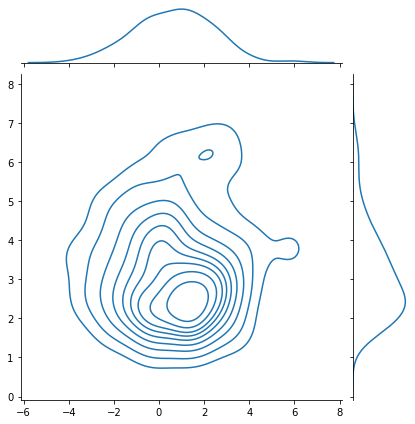

In [22]:
g = sns.jointplot(x = cpu_theta, 
                  y = cpu_energy,
                  kind='kde'
                 )
plt.show()

# Sample directly from GATA1 motif

In [11]:
motif = """1114.00 206.00 318.00 4955.00   0.00   0.00 2049.00 658.00 963.00 1191.00 1778.00 1038.00 1352.00 1885.00 1381.00 110.00 4659.00 160.00
2038.00 807.00   0.00   0.00   0.00 4955.00  63.00 1331.00 1214.00 1127.00 1130.00 1237.00 1142.00 1033.00 1237.00 4822.00   0.00 890.00
967.00 159.00   0.00   0.00   0.00   0.00  55.00 2214.00 1244.00 1520.00 990.00 1712.00 1466.00 820.00 1884.00  23.00   0.00 3544.00
836.00 3783.00 4637.00   0.00 4955.00   0.00 2788.00 752.00 1534.00 1117.00 1057.00 968.00 995.00 1217.00 453.00   0.00 296.00 361.00"""

In [12]:
def motif_str_to_counts(motif_str, pseudocounts=1.0):
    motif = torch.tensor( [ list([ float(y) for y in x.split() ]) for x in motif_str.split('\n') ] )
    return motif.add(pseudocounts)

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def PWM_to_filter(motif_str):
    motif = torch.tensor( [ list([ float(y) for y in x.split() ]) for x in motif_str.split('\n') ] )
    motif = motif.add(1.).div( motif.add(1.).sum(0) )
    motif = motif.div( motif.add(-1).mul(-1) ).log().clamp(-5,5)
    motif = torch.randn_like(motif).mul(1e-3).add(motif)
    motif = motif.add(-motif.mean(0))
    return motif

def counts_to_filter(in_tensor):
    motif = ppm_to_pwm( counts_to_ppm( in_tensor ) )
    return motif.unsqueeze(0)

In [13]:
ppm_to_pwm( counts_to_ppm( motif_str_to_counts(motif) ) )

tensor([[-1.5301e-01, -2.5823e+00, -1.9584e+00,  1.9991e+00, -1.0276e+01,
         -1.0276e+01,  7.2557e-01, -9.1170e-01, -3.6294e-01, -5.6665e-02,
          5.2102e-01, -2.5485e-01,  1.2611e-01,  6.0528e-01,  1.5671e-01,
         -3.4814e+00,  1.9103e+00, -2.9449e+00],
        [ 7.1781e-01, -6.1762e-01, -1.0276e+01, -1.0276e+01, -1.0276e+01,
          1.9991e+00, -4.2758e+00,  1.0354e-01, -2.9093e-02, -1.3628e-01,
         -1.3245e-01, -2.0379e-03, -1.1722e-01, -2.6181e-01, -2.0379e-03,
          1.9599e+00, -1.0276e+01, -4.7655e-01],
        [-3.5697e-01, -2.9539e+00, -1.0276e+01, -1.0276e+01, -1.0276e+01,
         -1.0276e+01, -4.4685e+00,  8.3726e-01,  6.0964e-03,  2.9497e-01,
         -3.2309e-01,  4.6648e-01,  2.4282e-01, -5.9460e-01,  6.0452e-01,
         -5.6909e+00, -1.0276e+01,  1.5157e+00],
        [-5.6675e-01,  1.6099e+00,  1.9035e+00, -1.0276e+01,  1.9991e+00,
         -1.0276e+01,  1.1697e+00, -7.1933e-01,  3.0819e-01, -1.4913e-01,
         -2.2871e-01, -3.5548e-01, -3.1

In [14]:
ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) )

tensor([[2.1451e-02, 3.8598e-02, 1.0615e-01, 1.9905e+00, 4.0163e-04, 4.0163e-04,
         3.5227e-01, 2.2778e-02, 3.7411e-03, 2.9400e-03, 1.5548e-02, 7.9133e-03,
         4.3075e-03, 2.6964e-02, 3.9090e-02, 4.0259e-02, 1.5670e+00, 2.5085e-02],
        [3.9227e-02, 1.5066e-01, 3.3275e-04, 4.0163e-04, 4.0163e-04, 1.9905e+00,
         1.0998e-02, 4.6039e-02, 4.7152e-03, 2.7822e-03, 9.8849e-03, 9.4289e-03,
         3.6389e-03, 1.4783e-02, 3.5017e-02, 1.7493e+00, 3.3626e-04, 1.3883e-01],
        [1.8623e-02, 2.9835e-02, 3.3275e-04, 4.0163e-04, 4.0163e-04, 4.0163e-04,
         9.6230e-03, 7.6559e-02, 4.8316e-03, 3.7515e-03, 8.6613e-03, 1.3047e-02,
         4.6704e-03, 1.1738e-02, 5.3318e-02, 8.7046e-03, 3.3626e-04, 5.5235e-01],
        [1.6102e-02, 7.0559e-01, 1.5433e+00, 4.0163e-04, 1.9905e+00, 4.0163e-04,
         4.7926e-01, 2.6027e-02, 5.9570e-03, 2.7575e-03, 9.2468e-03, 7.3802e-03,
         3.1709e-03, 1.7413e-02, 1.2842e-02, 3.6269e-04, 9.9868e-02, 5.6403e-02]])

In [15]:
from Bio.Seq import Seq
from Bio import motifs

import imageio

def two_pngs(png1,png2,target='compound_image.png',dpi=200):
    img1 = plt.imread(png1)
    img2 = plt.imread(png2)

    plt.figure(1,figsize=(12,6),dpi=dpi)
    plt.subplot(211)
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(img2)
    plt.axis('off')
    plt.savefig(target)
    plt.close()

def seqs_from_tensor(in_tensor):
    n_samples = 100
    samples = [ F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=0) 
                for i in range(n_samples) ]
    samples = torch.stack(samples, dim=0).argmax(1)
    seqs = []
    for i in range(samples.shape[0]):
        seqs.append(Seq("".join([ ['A','C','G','T'][x.item()] for x in samples[i] ])))
    return seqs

def logo_from_batch(in_tensor, target='my_motif.png'):
    token_tensor = F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=1).argmax(1)
    seqs = []
    for sample in token_tensor:
        seqs.append(Seq(''.join([ ['A','C','G','T'][x.item()] for x in sample ])))
    m = motifs.create(seqs)
    m.weblogo(target,**{'color_scheme': 'color_classic'})
    return m

def logo_from_tensor(in_tensor, target='my_motif.png'):
    instance = seqs_from_tensor(in_tensor)
    m        = motifs.create(instance)
    m.weblogo(target, **{'color_scheme': 'color_classic'})
    return m

def logo_gif(in_tensor, target='my_motif.gif'):
    images = []
    for an_instance in in_tensor:
        _ = logo_from_tensor(an_instance, target='temp_motif.png')
        images.append( imageio.imread('temp_motif.png') )
    imageio.mimsave(target, images, duration=0.01)
    return images

def logo_video(in_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=20)
    for an_instance in in_tensor:
        _ = logo_from_tensor(an_instance, target='temp_motif.png')
        images.append( imageio.imread('temp_motif.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images

def combo_video(theta_tensor, energy_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=20)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        _ = logo_from_tensor(a_theta, target='temp_motif.png')
        
        fig = plt.figure(figsize=(12,4))
        ax  = plt.axes()
        ax.plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        ax.set_xlim(0, energy_tensor.shape[0])
        ax.set_ylim(min_e, max_e)
        ax.set_ylabel('Potential Energy')
        ax.set_xlabel('Iteration')
        fig.savefig('temp_line.png')
        plt.close()
        
        two_pngs('temp_motif.png','temp_line.png','compound_image.png')
        
        images.append( imageio.imread('compound_image.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images
    
def pssm_to_bits(in_pssm):
    bits_mat = {}
    for NT, scores in in_pssm.items():
        bits_mat[NT] = [ 1. / (1 + (2**(-x))) for x in scores ]
    return bits_mat

In [184]:
import dmslogo
import palettable
import dmslogo.colorschemes
from dmslogo.colorschemes import CBPALETTE

def tensor_to_pandas(in_tensor):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(['A','C','G','T'],[ sub_a for sub_a in my_array ],['green','blue','orange','red']):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def counts_to_dms(in_tensor, ax=None):
    motif = counts_to_ppm( in_tensor )
    motif = ppm_to_IC( motif )
    motif = tensor_to_pandas( motif )
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                fixed_ymax=2.0,
                                ax=ax)
    return fig, ax

def tensor_to_dms(in_tensor, target='dms_motif.png', ax=None):
    n_samples = 1
    samples = [ F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=0) 
                for i in range(n_samples) ]
    samples = torch.stack(samples, dim=0).sum(0).add(0.01)
    fig, ax = counts_to_dms(samples, ax=ax)
    if target is not None:
        fig.savefig(target,dpi=400)
    return fig, ax
    
    
def batch_to_dms(in_tensor, target='dms_motif.png'):
    count_tensor = F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=1).sum(0).add(1.0)
    fig, ax = counts_to_dms(count_tensor)
    fig.savefig(target)
    return fig, ax

def dms_video(theta_tensor, energy_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=25)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        #_ = tensor_to_dms(a_theta, target='dms_motif.png')
        
        fig = plt.figure(figsize=(12,8))
        axes = fig.subplots(nrows=2)
        axes[1].plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        axes[1].set_xlim(0, energy_tensor.shape[0])
        axes[1].set_ylim(min_e, max_e)
        axes[1].set_ylabel('Potential Energy')
        axes[1].set_xlabel('Iteration')
        _ = tensor_to_dms(a_theta, target=None,ax=axes[0])
        fig.savefig('temp_line.png',dpi=100)
        plt.close()
        
        #two_pngs('dms_motif.png','temp_line.png','compound_image.png',dpi=400)
        
        images.append( imageio.imread('temp_line.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images

def dmsheat_video(theta_tensor, energy_tensor, scorer, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=15)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    scores = scorer(theta_tensor)
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        #_ = tensor_to_dms(a_theta, target='dms_motif.png')
        
        fig = plt.figure(figsize=(12,8))
        axes = fig.subplots(nrows=3)
        axes[0].imshow(scores[i].cpu().numpy(),vmin=scores.min(),vmax=scores.max())
        axes[2].plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        axes[2].set_xlim(0, energy_tensor.shape[0])
        axes[2].set_ylim(min_e, max_e)
        axes[2].set_ylabel('Potential Energy')
        axes[2].set_xlabel('Iteration')
        _ = tensor_to_dms(a_theta, target=None,ax=axes[1])
        fig.savefig('temp_line.png',dpi=100)
        plt.close()
        
        #two_pngs('dms_motif.png','temp_line.png','compound_image.png',dpi=400)
        
        images.append( imageio.imread('temp_line.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images



In [185]:
motif_filter = PWM_to_filter(motif).unsqueeze(0)
motif_filter = counts_to_filter( motif_str_to_counts(motif) )

In [186]:
ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) ).shape

torch.Size([4, 18])

In [187]:
hold_dms = tensor_to_pandas(ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) ))

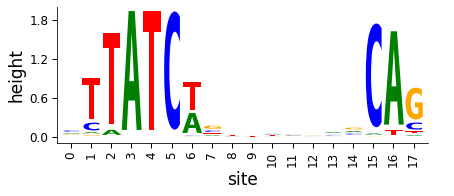

In [188]:
fig, ax = counts_to_dms( motif_str_to_counts(motif) )


In [189]:
hold = motifs.create(seqs_from_tensor(motif_filter.squeeze()))
hold.weblogo('testmotif.png',**{'color_scheme': 'color_classic'})

In [190]:
hold.pseudocounts = { x: .01 for x in hold.pseudocounts.keys()}

In [191]:
motif_filter.squeeze().t()

tensor([[-1.5301e-01,  7.1781e-01, -3.5697e-01, -5.6675e-01],
        [-2.5823e+00, -6.1762e-01, -2.9539e+00,  1.6099e+00],
        [-1.9584e+00, -1.0276e+01, -1.0276e+01,  1.9035e+00],
        [ 1.9991e+00, -1.0276e+01, -1.0276e+01, -1.0276e+01],
        [-1.0276e+01, -1.0276e+01, -1.0276e+01,  1.9991e+00],
        [-1.0276e+01,  1.9991e+00, -1.0276e+01, -1.0276e+01],
        [ 7.2557e-01, -4.2758e+00, -4.4685e+00,  1.1697e+00],
        [-9.1170e-01,  1.0354e-01,  8.3726e-01, -7.1933e-01],
        [-3.6294e-01, -2.9093e-02,  6.0964e-03,  3.0819e-01],
        [-5.6665e-02, -1.3628e-01,  2.9497e-01, -1.4913e-01],
        [ 5.2102e-01, -1.3245e-01, -3.2309e-01, -2.2871e-01],
        [-2.5485e-01, -2.0379e-03,  4.6648e-01, -3.5548e-01],
        [ 1.2611e-01, -1.1722e-01,  2.4282e-01, -3.1583e-01],
        [ 6.0528e-01, -2.6181e-01, -5.9460e-01, -2.5535e-02],
        [ 1.5671e-01, -2.0379e-03,  6.0452e-01, -1.4493e+00],
        [-3.4814e+00,  1.9599e+00, -5.6909e+00, -1.0276e+01],
        

In [192]:
my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([3,4,18])), 
    left_flank=None, 
    right_flank=None,
    n_samples=10,
    prior_var=1.
)

my_energy = scan_motif(motif_filter)

In [193]:
my_energy( my_params() )

tensor([35.0541, 36.7017, 40.5954, 47.7570, 31.3747, 47.5499, 57.5149, 55.1234,
        51.6811, 42.5707, 40.4266, -1.3925, 63.6484, 57.7815, 41.8285, 33.6583,
        52.0162, 56.4080, 51.3270, 45.5494, 29.7917, 46.3371, 45.1636, 28.4850,
        44.3203, 34.8853, 21.0947, 58.4068, 27.0781, 29.4389],
       grad_fn=<SumBackward1>)

In [194]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=6 )

In [195]:
my_sampler.calc_energy()

tensor([37.8916, 38.7041, 29.9810], grad_fn=<AddBackward0>)

In [196]:
my_sampler.params.theta

Parameter containing:
tensor([[[-0.5094,  0.7442, -0.0908,  0.0422,  1.2567, -2.3554, -1.1805,
           0.5317, -0.0640,  0.7314,  0.2950,  0.0412,  0.3949,  1.1852,
           0.6757, -0.1353,  0.5646, -0.6569],
         [ 0.1311,  0.1408, -0.9476, -0.7136,  0.2275, -1.4664, -1.2800,
           0.1827,  0.8680,  1.4181, -0.6523,  0.3473, -1.7558, -1.2598,
           0.0818, -0.4607, -0.3258, -0.4645],
         [ 1.1676, -0.0964,  0.1595, -0.0400,  0.9846, -0.2110,  0.1665,
          -1.2278, -0.4162,  0.5921,  0.4968, -0.5539, -1.8082, -0.2955,
          -1.0786, -0.0716, -0.5290,  2.5844],
         [ 1.9067,  1.1437, -0.4106,  0.1652, -0.1246, -0.9072, -0.4927,
          -0.4405, -1.3996, -1.2982,  1.3340, -1.3067, -0.6499, -0.6082,
           0.4475, -1.0456, -0.2530, -0.7913]],

        [[ 1.2336, -0.3167,  2.5896, -0.8872,  1.0455, -0.4919,  0.3327,
           0.1934, -0.2706,  0.5810, -0.1595, -1.6715,  2.2630, -2.3504,
          -0.0117,  0.1257, -0.0587, -0.6206],
         [-

In [197]:
my_sampler.params.theta.argmax(1)

tensor([[3, 3, 2, 3, 0, 2, 2, 0, 1, 1, 3, 1, 0, 0, 0, 2, 0, 2],
        [0, 1, 0, 2, 3, 1, 2, 2, 3, 2, 3, 3, 0, 2, 1, 3, 2, 1],
        [3, 0, 1, 1, 2, 1, 1, 3, 2, 3, 0, 2, 1, 0, 1, 1, 1, 1]])

In [198]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time() - start)

456.06550645828247


In [199]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [200]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 3, 4, 18])
torch.Size([1000, 3])


In [201]:
sampled_theta[:,:,:,5].softmax(-1)

tensor([[[3.4784e-04, 9.9959e-01, 1.9188e-05, 4.4770e-05],
         [6.5425e-06, 9.9999e-01, 7.5202e-07, 9.5789e-09],
         [2.2905e-08, 9.9987e-01, 6.5777e-05, 6.0500e-05]],

        [[2.3422e-06, 1.0000e+00, 9.6390e-08, 8.7794e-08],
         [1.0317e-05, 9.9999e-01, 1.3099e-06, 2.4265e-08],
         [1.3339e-08, 9.9982e-01, 1.8433e-05, 1.5900e-04]],

        [[2.1076e-04, 9.9941e-01, 8.2561e-05, 2.9643e-04],
         [8.2474e-08, 9.9999e-01, 8.3595e-06, 2.0501e-07],
         [2.2805e-08, 9.9779e-01, 3.0478e-07, 2.2131e-03]],

        ...,

        [[1.3362e-08, 1.0000e+00, 4.7239e-11, 2.3383e-07],
         [9.3001e-11, 9.9977e-01, 3.2032e-09, 2.2795e-04],
         [7.3244e-07, 9.9712e-01, 2.8757e-03, 5.4664e-09]],

        [[2.3113e-04, 9.9568e-01, 8.1595e-07, 4.0910e-03],
         [1.1511e-07, 9.9182e-01, 2.1317e-04, 7.9699e-03],
         [1.1479e-07, 9.9999e-01, 7.6645e-06, 8.1524e-10]],

        [[2.3113e-04, 9.9568e-01, 8.1595e-07, 4.0910e-03],
         [1.1511e-07, 9.9182e-01

(<Figure size 478.8x180 with 1 Axes>,
 <AxesSubplot:xlabel='site', ylabel='height'>)

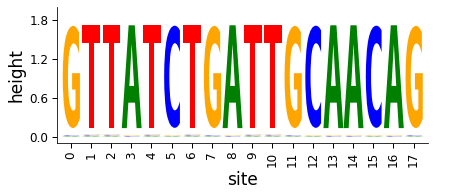

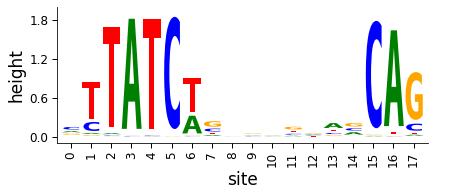

In [202]:
tensor_to_dms(motif_filter.squeeze())
batch_to_dms(sampled_theta[:,2])

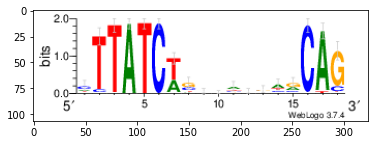

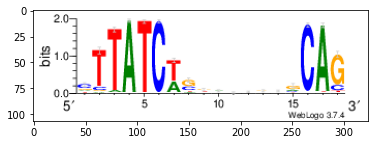

In [207]:
logo_from_tensor(motif_filter.squeeze(), 'filter_motif.png')
logo_from_batch(sampled_theta[:,0], 'sampled_motif.png')

img = mpimg.imread('filter_motif.png')
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread('sampled_motif.png')
imgplot = plt.imshow(img)
plt.show()

In [204]:
hold1 = logo_video(sampled_theta[:,0],'traj_1b.mp4')
hold2 = logo_video(sampled_theta[:,1],'traj_2b.mp4')
hold3 = logo_video(sampled_theta[:,2],'traj_3b.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


KeyboardInterrupt: 

In [206]:
hold1 = dms_video(sampled_theta[:,0], sampled_energy[:,0])

# Scan for motif

In [17]:
motif_filter = counts_to_filter( motif_str_to_counts(motif) )

In [18]:
motif_filter.shape


torch.Size([1, 4, 18])

In [19]:
motif_filter.squeeze().t()

tensor([[-1.5301e-01,  7.1781e-01, -3.5697e-01, -5.6675e-01],
        [-2.5823e+00, -6.1762e-01, -2.9539e+00,  1.6099e+00],
        [-1.9584e+00, -1.0276e+01, -1.0276e+01,  1.9035e+00],
        [ 1.9991e+00, -1.0276e+01, -1.0276e+01, -1.0276e+01],
        [-1.0276e+01, -1.0276e+01, -1.0276e+01,  1.9991e+00],
        [-1.0276e+01,  1.9991e+00, -1.0276e+01, -1.0276e+01],
        [ 7.2557e-01, -4.2758e+00, -4.4685e+00,  1.1697e+00],
        [-9.1170e-01,  1.0354e-01,  8.3726e-01, -7.1933e-01],
        [-3.6294e-01, -2.9093e-02,  6.0964e-03,  3.0819e-01],
        [-5.6665e-02, -1.3628e-01,  2.9497e-01, -1.4913e-01],
        [ 5.2102e-01, -1.3245e-01, -3.2309e-01, -2.2871e-01],
        [-2.5485e-01, -2.0379e-03,  4.6648e-01, -3.5548e-01],
        [ 1.2611e-01, -1.1722e-01,  2.4282e-01, -3.1583e-01],
        [ 6.0528e-01, -2.6181e-01, -5.9460e-01, -2.5535e-02],
        [ 1.5671e-01, -2.0379e-03,  6.0452e-01, -1.4493e+00],
        [-3.4814e+00,  1.9599e+00, -5.6909e+00, -1.0276e+01],
        

In [166]:
my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([4,4,64])), 
    left_flank=None, 
    right_flank=None,
    n_samples=1,
    prior_var=1.
)

my_energy = scan_motif(motif_filter)

In [167]:
my_energy( my_params() )

tensor([12.0811, 15.1788,  3.5198,  9.8733], grad_fn=<SumBackward1>)

In [168]:
my_params()

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]], grad_fn=<ViewBackward>)

In [169]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=6 )

In [170]:
my_sampler.calc_energy()

tensor([ 3.3071,  2.9615, 10.6279,  2.7180], grad_fn=<AddBackward0>)

In [171]:
my_sampler.params.theta

Parameter containing:
tensor([[[ 2.2816e+00,  8.4139e-01, -7.1625e-01,  ..., -2.9962e-01,
          -2.8876e-01, -1.4201e+00],
         [ 3.5305e-01,  2.3895e-03,  2.1923e+00,  ..., -1.5723e+00,
           6.7207e-01, -4.2886e-01],
         [ 9.9655e-01,  1.4501e+00,  3.7687e-01,  ...,  1.0208e-01,
           8.7017e-01, -5.8295e-01],
         [ 8.1939e-02, -5.0062e-01, -2.3940e+00,  ..., -1.0890e+00,
           8.5724e-01, -8.4424e-01]],

        [[-1.1404e+00,  8.4586e-01, -6.2984e-01,  ..., -1.9226e-01,
           1.2909e+00,  1.1769e+00],
         [-8.2393e-01,  5.8254e-02, -3.1235e-01,  ...,  7.5915e-01,
          -4.9882e-01, -1.1347e+00],
         [ 1.6008e-01,  5.9664e-01,  1.3900e+00,  ..., -1.6575e-01,
          -3.7885e-01,  8.5395e-01],
         [ 7.6023e-01,  4.3126e-01, -3.4187e-01,  ..., -4.8191e-01,
           1.4458e-01, -6.0549e-01]],

        [[ 7.2101e-01,  4.3527e-01, -1.6421e-01,  ..., -1.8536e+00,
           8.9701e-01, -9.2736e-01],
         [ 1.6045e-01,  1.495

In [172]:
my_sampler.params.theta.argmax(1)

tensor([[0, 2, 1, 1, 0, 0, 1, 2, 1, 0, 2, 2, 0, 3, 1, 3, 1, 0, 0, 2, 2, 3, 1, 3,
         0, 0, 1, 0, 0, 2, 1, 1, 3, 0, 3, 3, 0, 2, 2, 3, 2, 0, 1, 2, 0, 3, 1, 0,
         1, 2, 0, 0, 3, 3, 3, 3, 0, 1, 3, 2, 3, 2, 2, 1],
        [3, 0, 2, 1, 0, 2, 3, 0, 2, 0, 3, 2, 3, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 0, 3, 0, 1, 3, 3, 3, 1, 1, 1, 1, 0, 1, 2, 1, 2, 3, 0, 1, 2, 0, 0, 2,
         2, 2, 3, 0, 1, 3, 2, 1, 1, 1, 3, 0, 0, 1, 0, 0],
        [0, 1, 3, 0, 0, 3, 2, 2, 2, 3, 0, 0, 1, 0, 2, 1, 0, 0, 3, 1, 2, 2, 2, 1,
         2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 3, 2, 3, 2, 0, 1, 0, 2, 3, 1, 2,
         2, 2, 2, 2, 3, 2, 1, 0, 3, 3, 1, 1, 0, 3, 0, 3],
        [1, 1, 2, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 3, 1, 0, 0, 2, 0, 0,
         2, 3, 2, 0, 0, 3, 2, 1, 0, 3, 2, 3, 2, 0, 2, 0, 3, 2, 3, 1, 2, 1, 1, 2,
         2, 1, 3, 2, 1, 2, 2, 2, 3, 0, 2, 3, 2, 1, 0, 2]])

In [173]:
start = time.time()
my_samples = my_sampler.collect_samples(1.,1000)
print(time.time() - start)

234.52646207809448


In [174]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [175]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 4, 4, 64])
torch.Size([1000, 4])


In [30]:
logo_from_tensor(motif_filter.squeeze(), 'filter_motif.png')
logo_from_batch(sampled_theta[:,0], 'sampled_motif.png')

In [31]:
sampled_theta[:,:,:,6].softmax(-1)

tensor([[[4.5425e-04, 2.3058e-02, 9.5408e-01, 2.2404e-02],
         [1.1708e-08, 1.0000e+00, 1.1984e-10, 8.1960e-14]],

        [[3.0449e-16, 1.0000e+00, 1.4940e-18, 5.1500e-19],
         [3.5367e-11, 1.0000e+00, 1.4782e-06, 2.4617e-09]],

        [[2.4324e-08, 1.0000e+00, 4.1084e-08, 2.2348e-12],
         [5.6381e-21, 1.0000e+00, 4.7708e-16, 1.7942e-11]],

        ...,

        [[9.9997e-01, 2.6086e-05, 8.7557e-21, 2.4433e-23],
         [2.6958e-01, 5.4155e-01, 3.9425e-02, 1.4945e-01]],

        [[9.7161e-01, 2.8388e-02, 2.5353e-12, 6.6854e-08],
         [1.3767e-01, 6.0684e-01, 2.5469e-03, 2.5294e-01]],

        [[9.7161e-01, 2.8388e-02, 2.5353e-12, 6.6854e-08],
         [1.3767e-01, 6.0684e-01, 2.5469e-03, 2.5294e-01]]])

In [91]:
hold_s_1 = logo_video(sampled_theta[:,0],'traj_1d.mp4')
#hold2 = logo_video(sampled_theta[:,1],'traj_2b.mp4')
#hold3 = logo_video(sampled_theta[:,2],'traj_3b.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [55]:
hold_e = combo_video(sampled_theta[:20,0], sampled_energy[:20,0])

KeyboardInterrupt: 

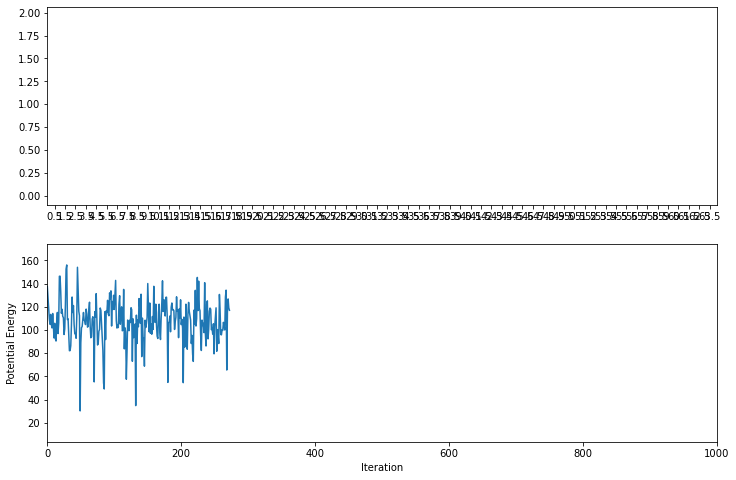

In [178]:
hold_d = dms_video(sampled_theta[:,0], sampled_energy[:,0])

In [67]:
check_me = run_filter(motif_filter)

In [84]:
check_me(sampled_theta[:,0]).squeeze()[908]

tensor([   0.0000, 1095.7001, 1095.7001, 1095.7001, 1095.7001, 1095.7001,
        3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442,
        3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442,
        3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442, 3408.0442,
        1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402,
        1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402,
        1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402, 1021.7402,
         919.1064,  919.1064,  919.1064,  919.1064,  919.1064,  919.1064,
         919.1064,  919.1064,  919.1064,  919.1064,  919.1064,  919.1064,
         919.1064,  919.1064,  919.1064,  919.1064,  919.1064,  919.1064,
           0.0000,    0.0000,    0.0000,    0.0000])

(<Figure size 1638x180 with 1 Axes>,
 <AxesSubplot:xlabel='site', ylabel='height'>)

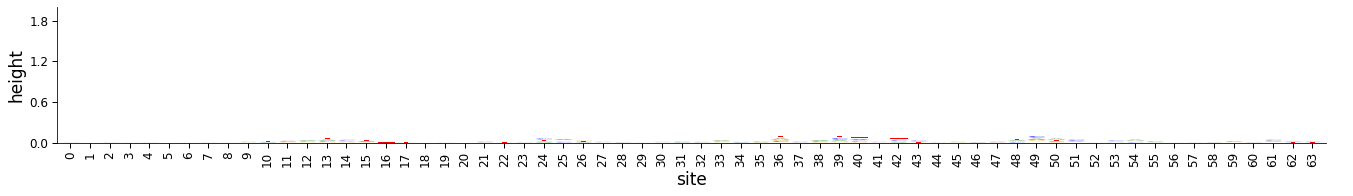

In [183]:
batch_to_dms(sampled_theta[:,1], target='dms_motif_1.png')


In [180]:
hold_h = dmsheat_video(sampled_theta[:,1], sampled_energy[:,0], check_me, target='test_motif_0.mp4')

In [181]:
hold_h = dmsheat_video(sampled_theta[:,1], sampled_energy[:,1], check_me, target='test_motif_1.mp4')

In [105]:
tensor_to_pandas(sampled_theta[0,0])

,site,letter,height,color
0,0,A,3.172076,green
1,1,A,4.757751,green
2,2,A,0.349964,green
3,3,A,3.829386,green
4,4,A,0.130407,green
...,...,...,...,...
67,13,T,2.188555,red
68,14,T,-2.300737,red
69,15,T,0.316460,red
70,16,T,2.774472,red


    site letter    height  color
0      0      A  1.598555  green
1      1      A  0.305983  green
2      2      A  0.001958  green
3      3      A  1.865755  green
4      4      A  0.054917  green
..   ...    ...       ...    ...
67    13      T  0.170156    red
68    14      T  0.014739    red
69    15      T  0.036716    red
70    16      T  1.148593    red
71    17      T  0.000892    red

[72 rows x 4 columns]
    site letter    height  color overlay_0
0      0      A  1.598555  green   #360e24
1      1      A  0.305983  green   #e6f1f1
2      2      A  0.001958  green   #e6f1f1
3      3      A  1.865755  green   #e6f1f1
4      4      A  0.054917  green   #e6f1f1
..   ...    ...       ...    ...       ...
67    13      T  0.170156    red   #e6f1f1
68    14      T  0.014739    red   #e6f1f1
69    15      T  0.036716    red   #e6f1f1
70    16      T  1.148593    red   #e6f1f1
71    17      T  0.000892    red   #e6f1f1

[72 rows x 5 columns]


(<Figure size 478.8x201.6 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:xlabel='site', ylabel='height'>],
       dtype=object))

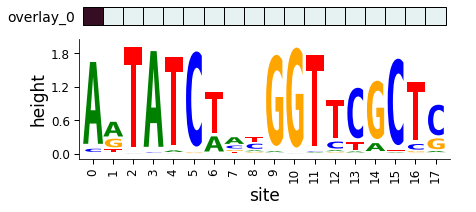

In [118]:
tensor_to_dmsheat(sampled_theta[0,0], check_me)

In [78]:
my_energy(sampled_theta[:,0])

tensor([-1449.7720, -1014.8062, -1508.8818, -1223.4364, -1630.4927, -1245.1487,
        -1757.7891, -1311.7988, -1199.5558, -1089.8500, -1341.6520,  -659.6882,
        -1078.9451, -1132.5225, -1309.1886, -1712.2198, -1548.0505, -1213.5634,
        -1353.2111, -1427.6747, -1346.4075, -1292.9281, -1485.9589, -1280.0656,
        -1415.1898, -1297.0605, -2485.5437, -1664.9291, -1155.6711, -1056.0938,
        -1532.5862, -2440.9524, -1828.5396, -2359.3958, -1881.5723, -1565.9161,
        -1222.3993, -1295.4130, -1495.6587, -1287.8323, -1310.8466, -1477.5900,
        -1755.6389, -1256.7096, -1133.5085, -2289.1780, -1780.7738, -1286.2808,
        -1492.7518, -1538.2177, -2198.0750, -1777.4636, -1738.0500, -1704.3945,
        -1950.1134, -1931.5438, -1945.4028, -2061.3599, -1626.6545, -1667.6465,
        -1074.5869, -1353.9261, -2385.3208, -1271.0945, -1980.7155, -1481.4163,
         -995.0934, -2385.1008, -2197.8855, -1213.6226, -1341.3950, -1744.7661,
        -1437.4288, -2829.3362, -2354.51

In [137]:
sampled_energy[-20:,0]

tensor([18.1644, 22.0910, 19.1911, 16.2472, 16.0655, 13.0726, 18.5254, 18.9793,
        15.7457, 15.8033, 15.3670,  8.0069,  9.1533, 13.7020, 12.5001, 13.8310,
        14.6548, 15.2760, 15.9075, 13.2945])

In [136]:
my_sampler.params.prior_nll()

tensor([28.6396], grad_fn=<MeanBackward1>)

In [148]:
my_sampler.params.theta.data = sampled_theta[-1,]

In [149]:
my_sampler.params.theta.shape

torch.Size([1, 4, 18])

In [151]:
my_energy( my_sampler.params.theta )

tensor([-1261.7211], grad_fn=<SumBackward1>)

In [150]:
my_sampler.params.rebatch( my_energy( my_sampler.params() ) )

tensor([-17.0434], grad_fn=<MeanBackward1>)

In [276]:
af2_auth = '''John Jumper, Richard Evans, Alexander Pritzel, Tim Green, Michael Figurnov, Kathryn Tunyasuvunakool, Olaf Ronneberger, Russ Bates, Augustin Žídek, Alex Bridgland, Clemens Meyer, Simon A A Kohl, Anna Potapenko, Andrew J Ballard, Andrew Cowie, Bernardino Romera-Paredes, Stanislav Nikolov, Rishub Jain, Jonas Adler, Trevor Back, Stig Petersen, David Reiman, Martin Steinegger, Michalina Pacholska, David Silver, Oriol Vinyals, Andrew W Senior, Koray Kavukcuoglu, Pushmeet Kohli, Demis Hassabis'''

" and ".join([ f'{x.split()[-1]}, {x.split()[0]}' for x in af2_auth.split(', ') ])

'Jumper, John and Evans, Richard and Pritzel, Alexander and Green, Tim and Figurnov, Michael and Tunyasuvunakool, Kathryn and Ronneberger, Olaf and Bates, Russ and Žídek, Augustin and Bridgland, Alex and Meyer, Clemens and Kohl, Simon and Potapenko, Anna and Ballard, Andrew and Cowie, Andrew and Romera-Paredes, Bernardino and Nikolov, Stanislav and Jain, Rishub and Adler, Jonas and Back, Trevor and Petersen, Stig and Reiman, David and Steinegger, Martin and Pacholska, Michalina and Silver, David and Vinyals, Oriol and Senior, Andrew and Kavukcuoglu, Koray and Kohli, Pushmeet and Hassabis, Demis'

In [92]:
seq_example = F.gumbel_softmax( sampled_theta[906,0], dim=0, hard=True ).t()[6:6+18].long().cpu().numpy()

In [91]:
filter_example = motif_filter.squeeze().cpu().numpy()

In [96]:
import array_to_latex as a2l
A = seq_example
a2l.to_ltx(A, frmt = '{}', arraytype = 'array')

\begin{array}
  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  1 \\
  0  &  0  &  0  &  1 \\
  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1 \\
  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  1 \\
  1  &  0  &  0  &  0 \\
  1  &  0  &  0  &  0 \\
  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1 \\
  0  &  1  &  0  &  0 \\
  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  1 \\
  0  &  0  &  1  &  0 \\
  0  &  1  &  0  &  0 \\
  1  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0 
\end{array}


In [100]:
import array_to_latex as a2l
A = filter_example.T
a2l.to_ltx(A, frmt = '{:6.2f}', arraytype = 'array')

\begin{array}
  -0.15 &    0.72 &  -0.36 &  -0.57\\
  -2.58 &  -0.62 &  -2.95 &    1.61\\
  -1.96 & -10.28 & -10.28 &    1.90\\
    2.00 & -10.28 & -10.28 & -10.28\\
 -10.28 & -10.28 & -10.28 &    2.00\\
 -10.28 &    2.00 & -10.28 & -10.28\\
    0.73 &  -4.28 &  -4.47 &    1.17\\
  -0.91 &    0.10 &    0.84 &  -0.72\\
  -0.36 &  -0.03 &    0.01 &    0.31\\
  -0.06 &  -0.14 &    0.29 &  -0.15\\
    0.52 &  -0.13 &  -0.32 &  -0.23\\
  -0.25 &  -0.00 &    0.47 &  -0.36\\
    0.13 &  -0.12 &    0.24 &  -0.32\\
    0.61 &  -0.26 &  -0.59 &  -0.03\\
    0.16 &  -0.00 &    0.60 &  -1.45\\
  -3.48 &    1.96 &  -5.69 & -10.28\\
    1.91 & -10.28 & -10.28 &  -2.06\\
  -2.94 &  -0.48 &    1.52 &  -1.78
\end{array}


In [107]:
(F.gumbel_softmax( sampled_theta[906,0], dim=0, hard=True )[:,6:6+18] * motif_filter.squeeze()).sum()

tensor(15.6838)

tensor(15.6838)


(<Figure size 478.8x180 with 1 Axes>,
 <AxesSubplot:xlabel='site', ylabel='height'>)

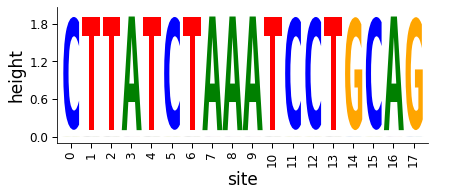

In [151]:
i=6
print((F.gumbel_softmax( sampled_theta[906,0], dim=0, hard=True )[:,i:i+18] * motif_filter.squeeze()).sum())
tensor_to_dms(sampled_theta[906,0,:,i:i+18].add(2).mul(80), target='example_hit.png')

tensor(-15.5759)


(<Figure size 478.8x180 with 1 Axes>,
 <AxesSubplot:xlabel='site', ylabel='height'>)

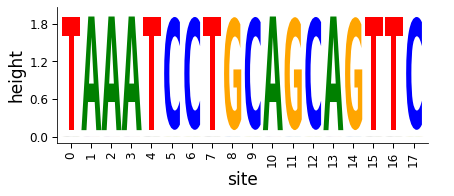

In [152]:
i=12
print((F.gumbel_softmax( sampled_theta[906,0], dim=0, hard=True )[:,i:i+18] * motif_filter.squeeze()).sum())
tensor_to_dms(sampled_theta[906,0,:,i:i+18].add(2).mul(80), target='example_miss.png')